In [18]:
#import library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import numpy as np
import zipfile, os

In [19]:
# ==========================
# 1. Parameter & Path
# ==========================
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 25

base_dir = "D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\DATASET\Dataset New"  

train_path = os.path.join(base_dir, "train")  
test_path = os.path.join(base_dir, "test")  

In [20]:
# ==========================
# 2. Data Augmentation
# ==========================
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

In [21]:
# ==========================
# 3. Load Dataset
# ==========================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=123
)

# Hanya load test_ds (tanpa val_ds)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    label_mode='categorical',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False  
)

class_names = train_ds.class_names
num_classes = len(class_names)

Found 2647 files belonging to 3 classes.
Found 1137 files belonging to 3 classes.


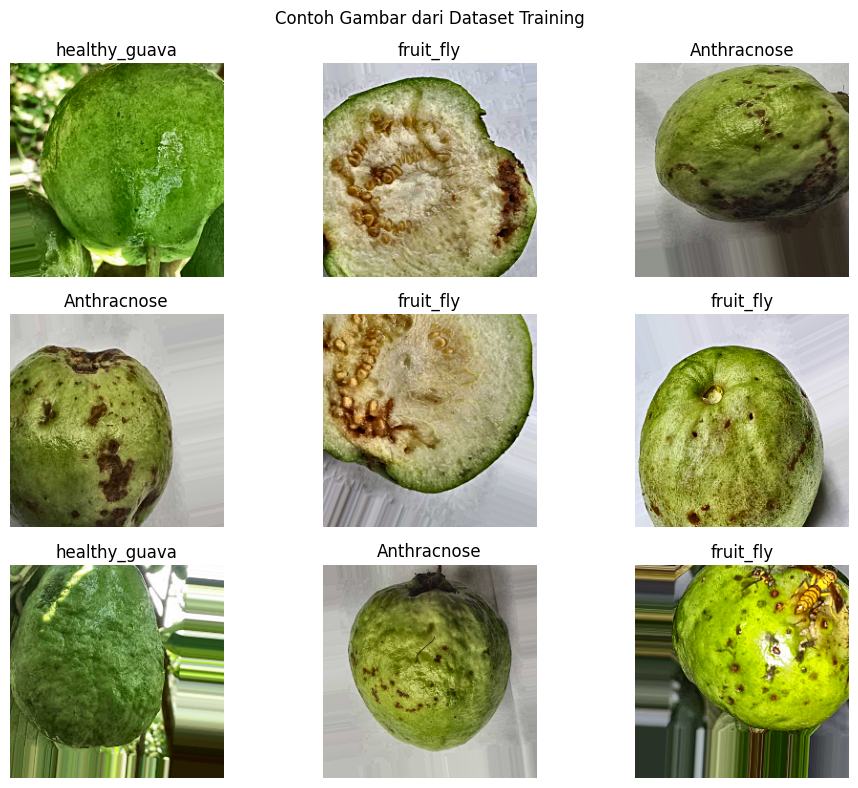

In [22]:
# Visualisasi beberapa gambar dari dataset training
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label_idx = tf.argmax(labels[i]).numpy()
        plt.title(class_names[label_idx])
        plt.axis("off")
plt.suptitle("Contoh Gambar dari Dataset Training")
plt.tight_layout()
plt.show()

In [23]:
# ==========================
# 4. ResNet50 Model
# ==========================
from tensorflow.keras import regularizers

base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=IMAGE_SIZE + (3,)
)

base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

inputs = layers.Input(shape=IMAGE_SIZE + (3,))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Dropout(0.6)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)

# Compile dengan learning rate sedikit lebih tinggi
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [24]:
# ==========================
# 5. Class Weights (Optional)
# ==========================
# Flatten labels for class_weight
y_train = np.concatenate([y for x, y in train_ds], axis=0)
y_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_labels), y=y_labels)
class_weights = dict(enumerate(class_weights))

In [25]:
# ==========================
# 6. Compile Model
# ==========================
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [26]:
# ==========================
# 7. Callbacks
# ==========================
callbacks = [
    tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_accuracy'),
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
]

In [27]:
# ==========================
# 8. Train
# ==========================
history = model.fit(
    train_ds,
    validation_data=test_ds,  # Gunakan test_ds sebagai validasi
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 88s 993ms/step - accuracy: 0.6791 - loss: 5.2129 - val_accuracy: 0.9886 - val_loss: 4.0554
Epoch 2/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 969ms/step - accuracy: 0.9817 - loss: 3.9385 - val_accuracy: 0.9921 - val_loss: 3.4684
Epoch 3/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 958ms/step - accuracy: 0.9915 - loss: 3.3450 - val_accuracy: 0.9903 - val_loss: 2.9461
Epoch 4/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 967ms/step - accuracy: 0.9928 - loss: 2.8399 - val_accuracy: 0.9947 - val_loss: 2.4874
Epoch 5/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 962ms/step - accuracy: 0.9937 - loss: 2.3926 - val_accuracy: 0.9974 - val_loss: 2.0927
Epoch 6/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 78s 944ms/step - accuracy: 0.9981 - loss: 2.0125 - val_accuracy: 0.9903 - val_loss: 1.7886
Epoch 7/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 79s 953ms/step - accuracy: 0.9954 - loss: 1.7002 - val_accuracy: 0.9930 - val_loss: 1.4992
Epoch 8/25
83/83 ━━━━━━━━━━━━━━━━━━━━ 80s 964ms/step - accuracy: 0.9946 - loss: 1.4396 - val_accu

In [28]:
# ==========================
# 9. Evaluate
# ==========================
loss, acc = model.evaluate(test_ds)
print(f"\nTest Accuracy: {acc:.4f}")


36/36 ━━━━━━━━━━━━━━━━━━━━ 22s 616ms/step - accuracy: 0.9936 - loss: 0.1004

Test Accuracy: 0.9947


In [29]:
# ==========================
# 10. Classification Report
# ==========================
from sklearn.metrics import classification_report


y_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_ds])
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Tampilkan classification report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

36/36 ━━━━━━━━━━━━━━━━━━━━ 24s 644ms/step

Classification Report:
               precision    recall  f1-score   support

  Anthracnose       1.00      0.99      1.00       464
    fruit_fly       0.99      0.99      0.99       394
healthy_guava       0.99      1.00      0.99       279

     accuracy                           0.99      1137
    macro avg       0.99      1.00      0.99      1137
 weighted avg       0.99      0.99      0.99      1137



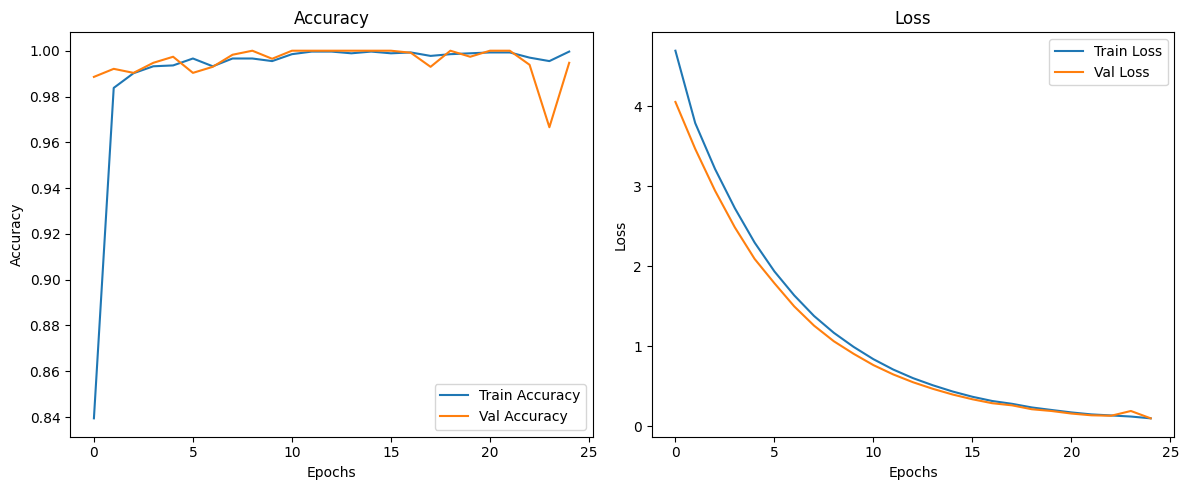

In [30]:
# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

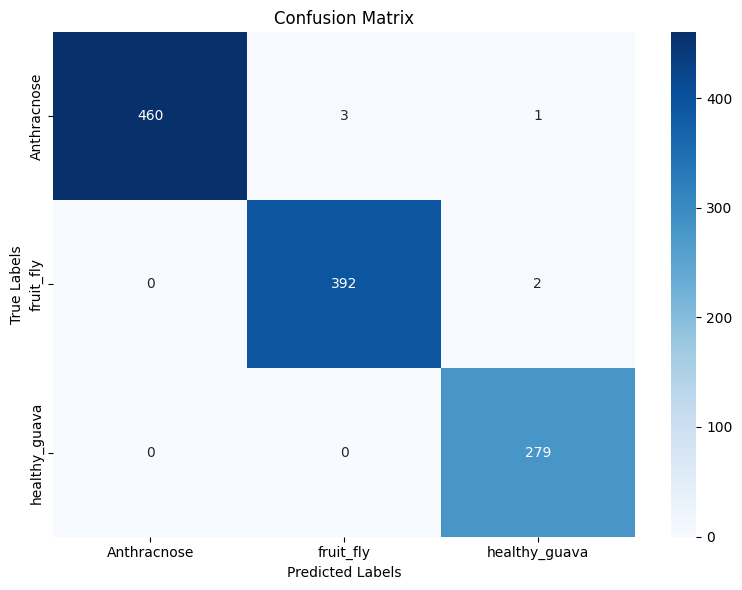

In [31]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


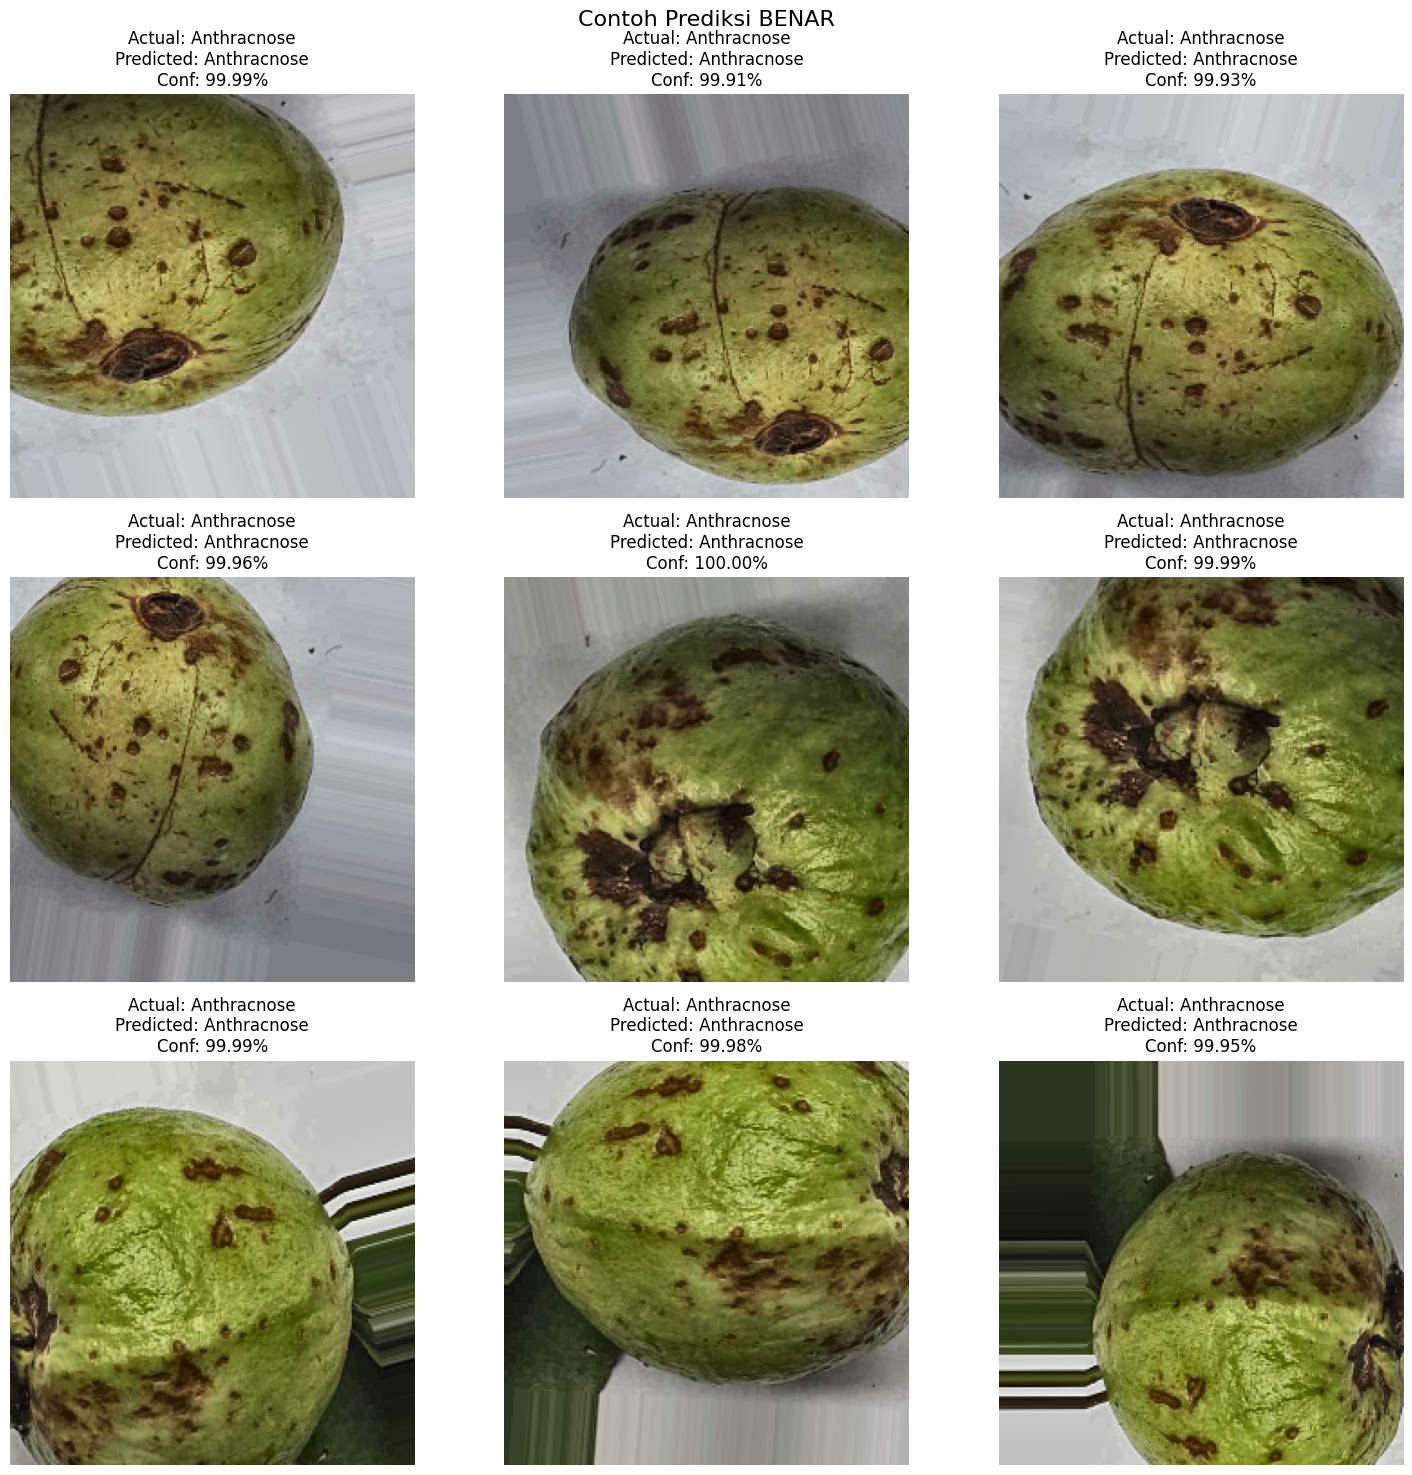

In [32]:
# Cell 16: Visualize Correct Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class == true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi BENAR", fontsize=16)
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

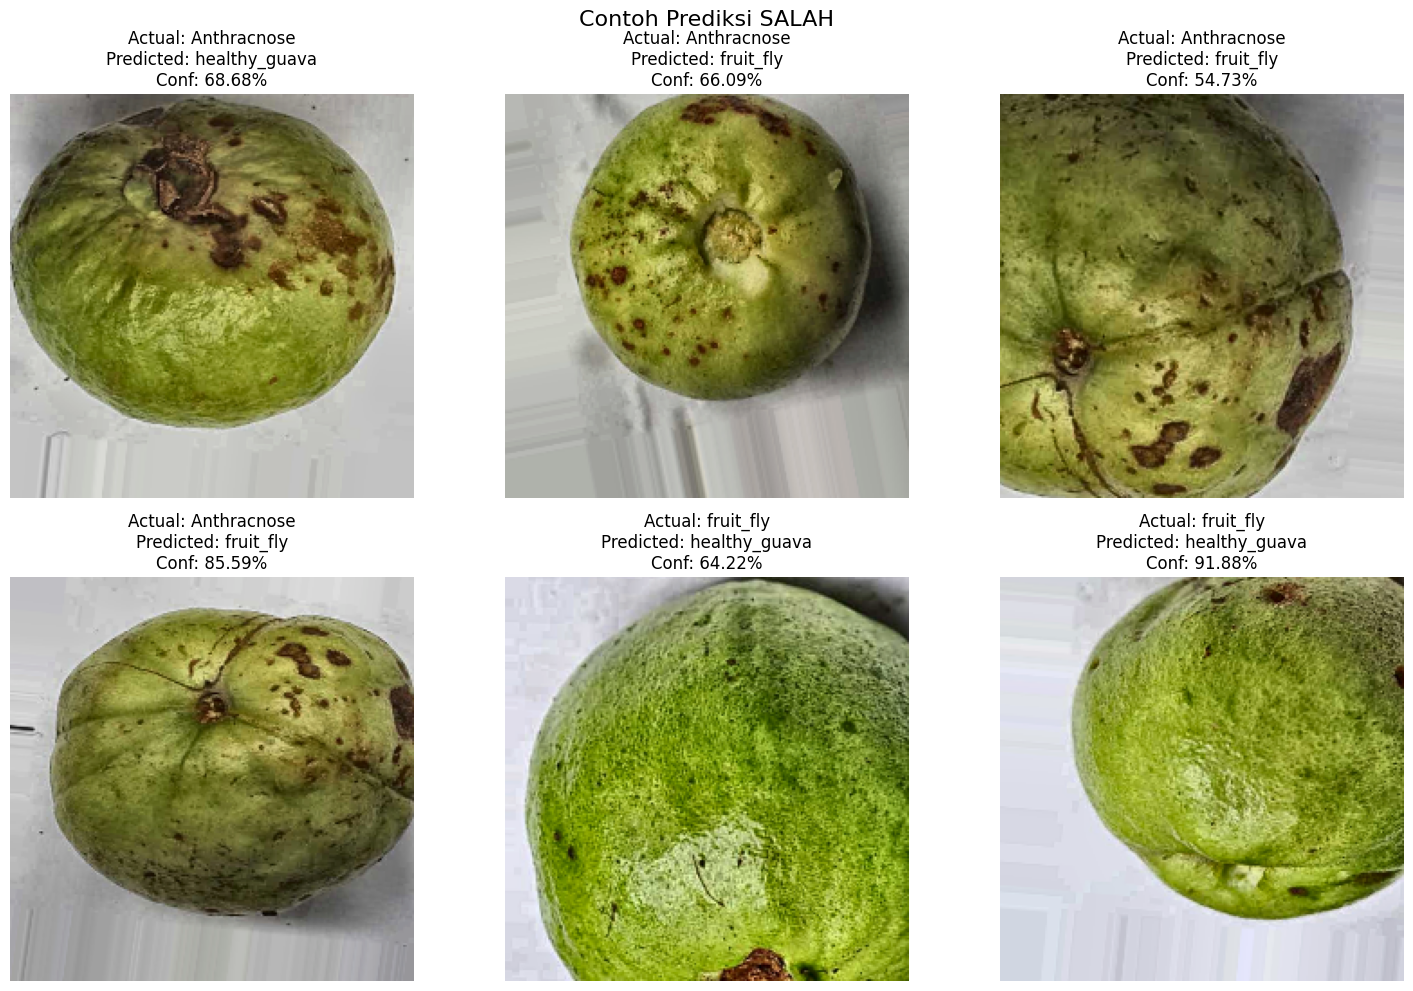

In [33]:
# Cell 17: Visualize Wrong Predictions

plt.figure(figsize=(15, 15))
shown = 0

for images, labels in test_ds.unbatch().batch(1):
    predictions = model.predict(images)
    pred_class = np.argmax(predictions[0])
    true_class = np.argmax(labels[0])

    if pred_class != true_class:
        ax = plt.subplot(3, 3, shown + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_class]}\nPredicted: {class_names[pred_class]}\nConf: {np.max(predictions[0])*100:.2f}%")
        plt.axis("off")
        shown += 1
        if shown == 9:
            break

plt.suptitle("Contoh Prediksi SALAH", fontsize=16)
plt.tight_layout()
plt.show()


In [34]:
# Save model terbaik
model.save("best_model.keras")

# Load model terbaik dari training
model = tf.keras.models.load_model("best_model.keras")

# Konversi ke TFLite (tanpa quantization untuk memastikan tidak rusak)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan ke file
tflite_model_path = r'D:\KULIAH UNDIP\SKRIPSI S NYA SANTUY\python\GuavaDisease_CNN_Model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

print("TFLite model exported to:", tflite_model_path)


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp4c7kuysm\assets


INFO:tensorflow:Assets written to: C:\Users\lenovo\AppData\Local\Temp\tmp4c7kuysm\assets


Saved artifact at 'C:\Users\lenovo\AppData\Local\Temp\tmp4c7kuysm'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_4')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  2559363599632: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  2556140268880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140261008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140270608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140267536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140271184: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140259856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140271568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140268496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2556140257744: TensorSpec(shape=(), dtype=tf.resource, name=No